In [3]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else cpu())
device

device(type='cuda')

## Load Data

#### Work on input (image) transformation

In [3]:
# whenever we have less data we use data Augmentation #-> rotate image , change brightness -> so that way we have variety

In [4]:
image_transforms  = transforms.Compose([   #used for image as input
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10), #10 degree rotation
    transforms.ColorJitter(brightness = 0.2 , contrast = 0.2),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]) # three channel(R,G,B) ,, -> This is mean and std for ImageNet dataset
])

In [5]:
# In every epoch image will rotate or flip or .....

#### declare path of image folder and apply transform to all image

In [6]:
dataset_path = "./dataset" # In my currentr directory
dataset = datasets.ImageFolder(root = dataset_path , transform = image_transforms) #Whenever you have folder of images you can use it
len(dataset)

2300

In [7]:
dataset.classes #Sub-Folders in Image Folder -> it implicitly assume it as classes

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [8]:
num_classes =  len(dataset.classes)
num_classes

6

#### train & test Data

In [9]:
train_size = int(0.75 * len(dataset))
val_size = len(dataset) - train_size

train_size , val_size

(1725, 575)

In [10]:
from torch.utils.data import random_split

train_dataset , val_dataset =  random_split(dataset , [train_size, val_size])

#### DataLoader -> batch size declaration

In [11]:
train_loader = DataLoader(train_dataset , batch_size =32 , shuffle = True )
val_loader = DataLoader(val_dataset , batch_size= 32 , shuffle = True)

In [12]:
for images, labels in train_loader:  # batch of 32 images // label -> cotegory -> front or back or .... damages
    print(images.shape)
    print(labels.shape) # classes number
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [13]:
labels[0] # tell the sub-folder name or category

tensor(2)

In [14]:
images[0].shape

torch.Size([3, 224, 224])

#### See image using imshow

In [15]:
images[0].permute(1,2,0).shape # change places of details in image or reorder

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


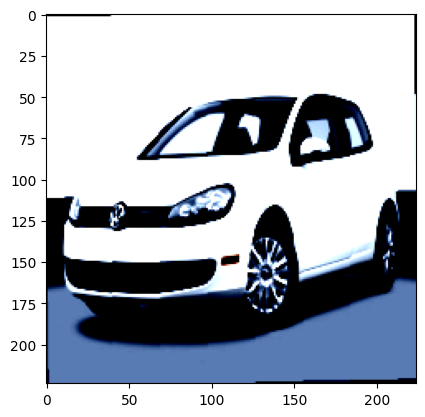

In [16]:
plt.imshow(images[0].permute(1,2,0)) # for imshow -> rgb needed in last postion
plt.show()

### Model 1: CNN

In [24]:
class CarClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__() # call super method of your parent class which is nn.module
        self.network = nn.Sequential(
            nn.Conv2d(in_channels= 3 , out_channels=16, kernel_size= 3 , stride=1 , padding = 1),#(16,224,224) #in_channels-> R,G,B  ,//# out_channels(feature_map)-> (no. of filter) = no. of convolution layer that you want to have ,//# kernal_size = 3 or (3,3) ,(//#stride=1  ,//#padding=1) -> (preserve the dimenstion of image) 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2 , stride = 2, padding = 0), #(16,112,112) #Reduce image into half when  kernal is 2 & stride is 2 ->help in image dimention
            nn.Conv2d(in_channels=16, out_chann els=32, kernel_size=3, stride=1, padding=1), #(32,112,112)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2 , stride=2, padding=0), #(32,56,56)
            nn.Conv2d(in_channels = 32, out_channels = 64 , kernel_size=3, stride=1, padding= 1), #(64,56,56) # capture 64 different features(patterns) -> it may be edges
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), #(64,28,28)
            nn.Flatten(),
            nn.Linear(64*28*28 , 512), # Fully connected dense layer have no. of inputs nuerons (64,28,28) output nueron 512 
            nn.ReLU(),
            nn.Linear(512, num_classes) #Output will be no. of classes -> In our term its sub-folder that is 6
        )
    def forward(self, x):
        x = self.network(x)
        return x

In [25]:
# Instantiate the model, loss function, and optimizer

model = CarClassifierCNN(num_classes = num_classes).to(device)
criterion = nn.CrossEntropyLoss() #Multiple category or classes that is 6 #if 2 we use Binary (BCE Loss)
optimizer = optim.Adam(model.parameters() , lr = 0.001) # you can try SGD or other , lr -> learning rate

In [34]:
def train_model(model , criterion, optimizer, epochs=5):
    start = time.time()
    
    for epoch in range(epochs):  
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):   # Inside each epoch you will itterate through mini batches -> here you get size of 32 batch of images
            images, labels = images.to(device), labels.to(device) #send it to GPU

            #Zero the parameter gradients
            optimizer.zero_grad() # zero out gradient so, you can start fresh

            #Forward Pass
            outputs =  model(images) # supply images to model and you get outputs
            loss = criterion(outputs , labels) # to figure out loss(difference between outputs(predicted labels) and labels(True/actual Labels))
            
            #Backward pass and optimization
            loss.backward() # compute gradients
            optimizer.step() # how udate your weights(weight = weight old- lr * partial derivative(apply chain rule))

            if (batch_num+1) % 10 == 0:  #Every 10th batch
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, loss: {loss.item():.2f}") # batch_num start with 0 so, batch_num +1

            running_loss += loss.item() * images.size(0) # measure running loss  (# measure loss across all the batches and then find out the average loss across the epoch)
                                        # loss -> tensor , loss.item() -> regular number value
                                        # images.size(0) -> nothing but a batch size // here it is 32
            #loss.item() -> average loss across batch of 32 images  and multiply with image.size(0) get total loss

            
        epoch_loss = running_loss / len(train_loader.dataset) # average loss for that epoch
        print(f"Epoch[{epoch+1}/{epoch}], Avg Loss: {epoch_loss:.4f}")
    
        # Validation
        model.eval # for every epoch I will do validation
        correct = 0
        total =0
        all_labels = []
        all_predictions = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device) , labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1) #dimension 1 , # predicted -> class 
                total += labels.size(0) # total number of labels
                correct += (predicted == labels).sum().item() # tensor (==) give bunch of 0 and 1 # how many correct prediction -> for measuring  accuracy for validation dataset
                all_labels.extend(labels.cpu().numpy())  # .extend -> add array  # .cpu() -> move to cpu because it is regular python list
                all_predictions.extend(predicted.cpu().numpy())

            print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")  # print the validation accuracy

    end = time.time()
    print(f" Execution time: {end - start} seconds")
    
    return all_labels, all_predictions

In [28]:
values ,indices = torch.max(torch.tensor([[10,12,15,9,2]]), 1)
values, indices
#value -> max value
#indices -> index value

(tensor([15]), tensor([2]))

In [37]:
all_labels, all_predictions =train_model(model, criterion, optimizer, epochs =5) # first check loss is reducing or not by passing only 1 epochs

Batch: 10, Epoch: 1, loss: 1.49
Batch: 20, Epoch: 1, loss: 0.90
Batch: 30, Epoch: 1, loss: 1.24
Batch: 40, Epoch: 1, loss: 1.22
Batch: 50, Epoch: 1, loss: 1.03
Epoch[1/0], Avg Loss: 1.0658
*** Validation Accuracy: 53.57% ***
Batch: 10, Epoch: 2, loss: 0.97
Batch: 20, Epoch: 2, loss: 0.79
Batch: 30, Epoch: 2, loss: 0.79
Batch: 40, Epoch: 2, loss: 1.11
Batch: 50, Epoch: 2, loss: 1.04
Epoch[2/1], Avg Loss: 1.0092
*** Validation Accuracy: 54.26% ***
Batch: 10, Epoch: 3, loss: 0.96
Batch: 20, Epoch: 3, loss: 1.10
Batch: 30, Epoch: 3, loss: 1.20
Batch: 40, Epoch: 3, loss: 0.99
Batch: 50, Epoch: 3, loss: 0.87
Epoch[3/2], Avg Loss: 0.9382
*** Validation Accuracy: 59.13% ***
Batch: 10, Epoch: 4, loss: 0.94
Batch: 20, Epoch: 4, loss: 0.74
Batch: 30, Epoch: 4, loss: 0.70
Batch: 40, Epoch: 4, loss: 0.84
Batch: 50, Epoch: 4, loss: 0.69
Epoch[4/3], Avg Loss: 0.8515
*** Validation Accuracy: 58.78% ***
Batch: 10, Epoch: 5, loss: 0.67
Batch: 20, Epoch: 5, loss: 0.72
Batch: 30, Epoch: 5, loss: 0.77
Batc

In [ ]:
# validation is around 50% that means model in  val/test data is not performing well (Overfitting)
# overfitting to training data -> training loss is very less
# but loss in unseen data(val_data) is higher

### Overfitting Issue Tackle

In [ ]:
#n Regularization -> add droupout layer -> batch normalization

In [2]:
# nn.BatchNorm2d(16),
# nn.Dropout(0.5), 
# , weight_dacay=1e-4)  # Using this 3 regularization

### Model 1: CNN with Regularization

In [24]:
class CarClassifierCNNwithRegularization(nn.Module):
    def __init__(self, num_classes):
        super().__init__() # call super method of your parent class which is nn.module
        self.network = nn.Sequential(
            nn.Conv2d(in_channels= 3 , out_channels=16, kernel_size= 3 , stride=1 , padding = 1),#(16,224,224) #in_channels-> R,G,B  ,//# out_channels(feature_map)-> (no. of filter) = no. of convolution layer that you want to have ,//# kernal_size = 3 or (3,3) ,(//#stride=1  ,//#padding=1) -> (preserve the dimenstion of image) 
            nn.BatchNorm2d(16),#Batch_Normalization #no. of output_channel in previous layer =16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2 , stride = 2, padding = 0), #(16,112,112) #Reduce image into half when  kernal is 2 & stride is 2 ->help in image dimention
            nn.Conv2d(in_channels=16, out_chann els=32, kernel_size=3, stride=1, padding=1), #(32,112,112)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2 , stride=2, padding=0), #(32,56,56)
            nn.Conv2d(in_channels = 32, out_channels = 64 , kernel_size=3, stride=1, padding= 1), #(64,56,56) # capture 64 different features(patterns) -> it may be edges
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), #(64,28,28)
            nn.Flatten(),
            nn.Linear(64*28*28 , 512), # Fully connected dense layer have no. of inputs nuerons (64,28,28) output nueron 512 
            nn.ReLU(),
            nn.Dropout(0.5), #Regularization
            nn.Linear(512, num_classes) #Output will be no. of classes -> In our term its sub-folder that is 6
        )
    def forward(self, x):
        x = self.network(x)
        return x

In [ ]:
model = CarClassifierCNNwithRegularization(num_classes = num_classes).to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters() , lr = 0.001 , weight_dacay=1e-4)  #weight_decay is l2 regularization ->  (1e-4) -> 0.0001

train_model(model, criterion, optimizer, epochs=10)

In [ ]:
#Regularization is not working here -> Infact it decreace the accuray than earlier
#reason :- Our training dataset (very less data to train)
#Solution :- Aquire more data (which take time or also money)
#So, we use Transfer Learning

#### Model 3: Transfer Learning with EfficientNet

In [9]:
model = models.efficientnet_b0(weights='DEFAULT')
model.classifier[1].in_features

1280

In [7]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')
        for param in self.model.parameters():    #This are the a weights       # You need to freeze previous layer otherwise it will try to learn based on new data
            param.requires_grad = False  #Do not required gradient Computation # Which means it is freezing all the layers
        # Now you have weights of 40 million images from imagenet trained data so they have learned all the features
            
        in_features = self.model.classifier[1].in_features  # Give no. of input connections
        
        self.model.classifier = nn.Sequential(            # Not freezing # Now using above learened feature only for this layer(classifier) and train through the real images that is 1700 
            nn.Dropout(0.5), # for regularization
            nn.Linear(in_features , num_classes)
        )                                           # Last Fully Connected layer which has a Dropout layer and then a fully connected layer

    def forward(self, x):
        x= self.model(x)
        return x

In [ ]:
model = CarClassifierEfficientNet(num_classes = num_classes).to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()) , lr = 0.001)  #Filter those parameter which has param.requires_grad = False above
# parameters that reqiures_grad computation only pass that to your optimizer

train_model(model, criterion, optimizer, epochs=10)

#### Model 4: Transfer Learning with ResNet

In [ ]:
class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        #freeze all layer except the final fully connected layer
        for param in self.model.parameters():   
            param.requires_grad = False  
       
        #Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():  # here layer 4 is last part so we unfreeze that
            param.requires_grad = True                  # learn from new data

        #Replace the final fully connected layer
        self.model.fc = nn.Sequential(             
            nn.Dropout(0.5), 
            nn.Linear(self.model.fc.in_features , num_classes)
        )                                          

    def forward(self, x):
        x= self.model(x)
        return x

In [ ]:
model = CarClassifierResNet(num_classes = num_classes).to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()) , lr = 0.001)  #Filter those parameter which has param.requires_grad = False above
# parameters that reqiures_grad computation only pass that to your optimizer

train_model(model, criterion, optimizer, epochs=10)

In [ ]:
# Resnet Increase accuracy about 80%

In [ ]:
### Hyperparameter tuning